In [1]:
import logging
import os
import random
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
# import torchvision
# import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import wandb
from source.domain.pytorch_wrappers import EarlyStopping

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

2023-12-29 19:16:51 - ERROR    | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shane-kercheval. Use `wandb login --relogin` to force relogin


True

In [3]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.astype(int).values, dtype=torch.long)

# need to make this dynamic based on Fully Connected vs Convolutional
# Reshape data to have channel dimension
# MNIST images are 28x28, so we reshape them to [batch_size, 1, 28, 28]
x = x.reshape(-1, 1, 28, 28)

# 80% train; 10% validation; 10% test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f"Training set  : X-{x_train.shape}, y-{y_train.shape}")
print(f"Validation set: X-{x_val.shape}, y-{y_val.shape}")
print(f"Test set      : X-{x_test.shape}, y-{y_test.shape}")

Training set  : X-torch.Size([56000, 1, 28, 28]), y-torch.Size([56000])
Validation set: X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])
Test set      : X-torch.Size([7000, 1, 28, 28]), y-torch.Size([7000])


In [4]:
class ConvNet(nn.Module):
    """Convolutional neural network (two convolutional layers)."""

    def __init__(self, kernels: list, classes: int = 10):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

In [5]:
def make_loader(x: torch.tensor, y: torch.tensor, batch_size: int) -> DataLoader:
    """Make a DataLoader from a given dataset."""
    return DataLoader(
        dataset=TensorDataset(x, y),
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )


def make(config: dict) -> tuple:
    """Make the model, data, and optimization objects."""
    # Make the data
    train_loader = make_loader(x_train, y_train, batch_size=config.batch_size)
    validation_loader = make_loader(x_val, y_val, batch_size=config.batch_size)
    test_loader = make_loader(x_test, y_test, batch_size=config.batch_size)

    # Make the model
    model = ConvNet(config.kernels, config.classes).to(DEVICE)

    # Make the loss and optimizer
    criterion = nn.CrossEntropyLoss()

    if config.optimizer == 'Adam':
        optimizer_creator = lambda lr: torch.optim.Adam(model.parameters(), lr=lr)  # noqa: E731
    elif config.optimizer == 'SGD':
        optimizer_creator = lambda lr: torch.optim.SGD(model.parameters(), lr=lr)  # noqa: E731
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer}")

    learning_rates = config.learning_rates
    if isinstance(learning_rates, float):
        learning_rates = [learning_rates]

    return (
        model,
        train_loader,
        validation_loader,
        test_loader,
        criterion,
        optimizer_creator,
        learning_rates,
    )


def train_log(training_loss: float, validation_loss: float, example_ct: int, epoch: int) -> None:
    """Logs loss to the console and wandb."""
    # Where the magic happens
    wandb.log(
        {
            'epoch': epoch,
            'training_loss': training_loss,
            'validation_loss': validation_loss,
        },
        step=example_ct,
    )
    print(
        f"Training/Validation Loss after {str(example_ct).zfill(5)} examples: ",
        f"{training_loss:.3f} | {validation_loss:.3f}",
    )


def calculate_average_loss(
        data_loader: DataLoader,
        model: nn.Module,
        loss_func: callable) -> float:
    """Calculates the average loss over a dataset."""
    running_loss = 0
    total_samples = 0
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)  # noqa: PLW2901
            loss = loss_func(model(x), y)
            # weighted average of the loss adjusted for the batch size
            running_loss += loss.item() * x.shape[0]
            total_samples += x.shape[0]
    return running_loss / total_samples


def train(
        model: nn.Module,
        train_loader: DataLoader,
        validation_loader: DataLoader,
        criterion: callable,
        optimizer_creator: callable,
        learning_rates: list[float],
        config: dict) -> None:
    """
    Trains the model for the number of epochs specified in the config. Uses early stopping to
    prevent overfitting. Takes multiple learning rates and if early stopping is triggered, the
    learning rate is reduced and training is continued until no learning rates remain.
    """
    model.train()
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    example_ct = 0  # number of examples seen

    log_interval = 30 # i.e. every 30 batches
    total_batches = len(train_loader)
    log_interval = max(1, math.floor(total_batches / log_interval))

    early_stopping = EarlyStopping(
        model=model,
        patience=3,
        delta=0.05,  # new loss is required to be >%5 better than previous best
        delta_type='relative',
        verbose=True,
    )
    learning_rate = learning_rates.pop(0)
    optimizer = optimizer_creator(lr=learning_rate)
    for epoch in tqdm(range(config.epochs)):
        print(f"Epoch {epoch} - learning rate: {learning_rate}")
        running_training_loss = 0
        total_train_samples = 0
        for batch_index, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)  # noqa: PLW2901
            # ➡ Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            # ⬅ Backward pass & optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            example_ct += len(x_batch)
            # weighted average of the training loss
            running_training_loss += loss.item() * x_batch.shape[0]
            total_train_samples += x_batch.shape[0]
            # Report metrics every 25th batch
            if batch_index % log_interval == 0:
                avg_training_loss = running_training_loss / total_train_samples
                running_training_loss = 0
                total_train_samples = 0
                model.eval()
                average_validation_loss = calculate_average_loss(
                    data_loader=validation_loader, model=model, loss_func=criterion,
                )
                train_log(avg_training_loss, average_validation_loss, example_ct, epoch)
                model.train()

        if early_stopping(average_validation_loss):
            print("Early stopping")
            # we have stopped training (for this learning rate), load the previous best state
            model.load_state_dict(early_stopping.best_state)
            # if we have more learning rates, reset the optimizer and early stopping and
            # continue training
            if learning_rates:
                learning_rate = learning_rates.pop(0)
                print(f"Reducing learning rate: {learning_rate}")
                optimizer = optimizer_creator(lr=learning_rate)
                early_stopping.reset()
            else:
                break


def plot_misclassified_sample(
        num_images: int,
        images: torch.tensor,
        predictions: np.array,
        labels: np.array) -> None:
    """Plot a sample of the misclassified images."""
    fig, ax = plt.subplots(nrows=num_images // 5, ncols=5, sharex=True, sharey=True)
    ax = ax.flatten()
    mismatched_indexes = np.where(predictions != labels)[0]
    rows = np.random.choice(mismatched_indexes, size=num_images, replace=False)  # noqa: NPY002
    for i, row in enumerate(rows):
        # img = X_test[row].cpu().numpy().reshape(28, 28)
        img = images[row].cpu().numpy().reshape(28, 28)
        ax[i].imshow(img, cmap='Greys')
        title_color = 'red' if predictions[row] != y_test[row] else 'black'
        ax[i].set_title(f'P:{predictions[row]} - A:{y_test[row]}', color=title_color)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    wandb.log({'sample-misclassified': wandb.Image(fig)})


def plot_heatmap(predictions: np.array, labels: np.array) -> None:
    """Plot a heatmap of the misclassified samples."""
    # create a heatmap of misclassified samples
    cm = confusion_matrix(labels, predictions)
    # remove the diagonal values (correct predictions) for better visualization
    np.fill_diagonal(cm, 0)
    fig = plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Count of Misclassified Samples by Class')
    wandb.log({'count-misclassified': wandb.Image(fig)})


def plot_scores(precision: list, recall: list, f1: list) -> None:
    """Plot the precision, recall, and f1 scores for each class."""
    # create a bar plot
    x = range(10)
    width = 0.2
    fig, ax = plt.subplots()
    _ = ax.bar(x, precision, width, label='Precision')
    _= ax.bar([i + width for i in x], recall, width, label='Recall')
    _ = ax.bar([i + 2 * width for i in x], f1, width, label='F1')
    # add labels, title, and legend
    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Accuracy Metrics by Class')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(range(10))
    ax.legend()
    # find the minimum and maximum score values (from precision, recall, and f1 lists) and set the
    # y limits slightly wider to make the plot easier to read
    ymin = min(*precision, *recall, *f1)
    ymax = max(*precision, *recall, *f1)
    ax.set_ylim([ymin - 0.03, min(ymax + 0.03, 1)])
    wandb.log({'scores': wandb.Image(fig)})


def test(model: nn.Module, test_loader: DataLoader, criterion: callable) -> None:
    """Tests the model on the test set. Logs the accuracy to the console and to wandb."""
    model.eval()
    avg_test_loss = calculate_average_loss(data_loader=test_loader, model=model, loss_func=criterion)  # noqa
    print(f"Average Loss on test set: {avg_test_loss:.3f}")
    wandb.log({'test_loss': avg_test_loss})

    # Log confusion matrix
    with torch.no_grad():
        all_predictions = []
        all_labels = []
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.cpu().numpy()  # noqa: PLW2901
            outputs = model(x)
            predictions = torch.argmax(outputs.data, dim=1).cpu().numpy()
            all_predictions.extend(predictions)
            all_labels.extend(y)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    plot_misclassified_sample(num_images=30, images=x_test, predictions=all_predictions, labels=all_labels)  # noqa
    plot_heatmap(predictions=all_predictions, labels=all_labels)

    # for each class, calculate the accuracy metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_true=all_labels, y_pred=all_predictions)  # noqa
    score_table = wandb.Table(columns=["class", "precision", "recall", "f1"])
    for i in range(10):
        score_table.add_data(str(i), precision[i], recall[i], f1[i])
    wandb.log({"score_table": score_table})
    plot_scores(precision, recall, f1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true=all_labels,
        y_pred=all_predictions,
        average='weighted',
    )
    print(f"Weighted Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
    wandb.log({'weighted_precision': precision, 'weighted_recall': recall, 'weighted_f1': f1})

    # Save the model in the exchangeable ONNX format
    x, _ = next(iter(test_loader))
    torch.onnx.export(model, x.to(DEVICE) , 'model.onnx')
    wandb.save('model.onnx')


def model_pipeline(config: dict) -> nn.Module:
    """Builds the model and runs it."""
    # tell wandb to get started
    project = config.pop('project'); assert project
    tags = config.pop('tags', None)
    notes = config.pop('notes', None)
    with wandb.init(project=project, config=config, tags=tags, notes=notes):
        config = wandb.config
        # make the model, data, and optimization problem
        model, train_loader, validation_loader, test_loader, criterion, optimizer_creator, \
            learning_rates = make(config)
        print(model)
        # and use them to train the model
        train(
            model, train_loader, validation_loader, criterion, optimizer_creator,
            learning_rates, config,
        )
        # and test its final performance
        test(model, test_loader, criterion)

    return model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 - learning rate: 0.005
Training/Validation Loss after 00064 examples:  24.292 | 91.698
Training/Validation Loss after 01920 examples:  7.539 | 1.284
Training/Validation Loss after 03776 examples:  1.003 | 0.789
Training/Validation Loss after 05632 examples:  0.732 | 0.620
Training/Validation Loss after 07488 examples:  0.586 | 0.560
Training/Validation Loss after 09344 examples:  0.529 | 0.432
Training/Validation Loss after 11200 examples:  0.430 | 0.457
Training/Validation Loss after 13056 examples:  0.408 | 0.329
Training/Validation Loss after 14912 examples:  0.370 | 0.398
Training/Validation Loss after 16768 examples:  0.334 | 0.283
Training/Validation Loss after 18624 examples:  0.329 | 0.331
Training/Validation Loss after 20480 examples:  0.294 | 0.280
Training/Validation Loss after 22336 examples:  0.263 | 0.342
Training/Validation Loss after 24192 examples:  0.309 | 0.290
Training/Validation Loss after 26048 examples:  0.298 | 0.243
Training/Validation Loss after 27904 

2023-12-29 19:17:10 - INFO     | Validation loss decreased (inf --> 0.233049). Caching model state.
  5%|▌         | 1/20 [00:11<03:32, 11.19s/it]

Training/Validation Loss after 55744 examples:  0.249 | 0.233
Epoch 1 - learning rate: 0.005
Training/Validation Loss after 56064 examples:  0.238 | 0.193
Training/Validation Loss after 57920 examples:  0.212 | 0.234
Training/Validation Loss after 59776 examples:  0.247 | 0.257
Training/Validation Loss after 61632 examples:  0.195 | 0.220
Training/Validation Loss after 63488 examples:  0.196 | 0.233
Training/Validation Loss after 65344 examples:  0.203 | 0.259
Training/Validation Loss after 67200 examples:  0.171 | 0.232
Training/Validation Loss after 69056 examples:  0.194 | 0.220
Training/Validation Loss after 70912 examples:  0.218 | 0.216
Training/Validation Loss after 72768 examples:  0.224 | 0.199
Training/Validation Loss after 74624 examples:  0.202 | 0.221
Training/Validation Loss after 76480 examples:  0.194 | 0.201
Training/Validation Loss after 78336 examples:  0.221 | 0.226
Training/Validation Loss after 80192 examples:  0.224 | 0.241
Training/Validation Loss after 82048 ex

2023-12-29 19:17:20 - INFO     | Validation loss decreased (0.233049 --> 0.212299). Caching model state.
 10%|█         | 2/20 [00:21<03:16, 10.94s/it]

Training/Validation Loss after 111744 examples:  0.220 | 0.212
Epoch 2 - learning rate: 0.005
Training/Validation Loss after 112064 examples:  0.146 | 0.197
Training/Validation Loss after 113920 examples:  0.204 | 0.196
Training/Validation Loss after 115776 examples:  0.180 | 0.188
Training/Validation Loss after 117632 examples:  0.190 | 0.234
Training/Validation Loss after 119488 examples:  0.178 | 0.194
Training/Validation Loss after 121344 examples:  0.161 | 0.184
Training/Validation Loss after 123200 examples:  0.176 | 0.203
Training/Validation Loss after 125056 examples:  0.240 | 0.184
Training/Validation Loss after 126912 examples:  0.194 | 0.211
Training/Validation Loss after 128768 examples:  0.214 | 0.191
Training/Validation Loss after 130624 examples:  0.189 | 0.209
Training/Validation Loss after 132480 examples:  0.222 | 0.260
Training/Validation Loss after 134336 examples:  0.212 | 0.263
Training/Validation Loss after 136192 examples:  0.217 | 0.235
Training/Validation Loss

2023-12-29 19:17:31 - INFO     | Early Stopping counter: 1 out of 3
 15%|█▌        | 3/20 [00:32<03:04, 10.86s/it]

Training/Validation Loss after 167744 examples:  0.183 | 0.209
Epoch 3 - learning rate: 0.005
Training/Validation Loss after 168064 examples:  0.089 | 0.219
Training/Validation Loss after 169920 examples:  0.184 | 0.202
Training/Validation Loss after 171776 examples:  0.169 | 0.180
Training/Validation Loss after 173632 examples:  0.166 | 0.196
Training/Validation Loss after 175488 examples:  0.177 | 0.234
Training/Validation Loss after 177344 examples:  0.231 | 0.232
Training/Validation Loss after 179200 examples:  0.234 | 0.215
Training/Validation Loss after 181056 examples:  0.199 | 0.225
Training/Validation Loss after 182912 examples:  0.170 | 0.186
Training/Validation Loss after 184768 examples:  0.164 | 0.212
Training/Validation Loss after 186624 examples:  0.178 | 0.214
Training/Validation Loss after 188480 examples:  0.217 | 0.209
Training/Validation Loss after 190336 examples:  0.196 | 0.208
Training/Validation Loss after 192192 examples:  0.180 | 0.192
Training/Validation Loss

2023-12-29 19:17:42 - INFO     | Validation loss decreased (0.212299 --> 0.169809). Caching model state.
 20%|██        | 4/20 [00:43<02:52, 10.78s/it]

Training/Validation Loss after 223744 examples:  0.191 | 0.170
Epoch 4 - learning rate: 0.005
Training/Validation Loss after 224064 examples:  0.609 | 0.193
Training/Validation Loss after 225920 examples:  0.162 | 0.174
Training/Validation Loss after 227776 examples:  0.147 | 0.186
Training/Validation Loss after 229632 examples:  0.171 | 0.165
Training/Validation Loss after 231488 examples:  0.220 | 0.197
Training/Validation Loss after 233344 examples:  0.172 | 0.186
Training/Validation Loss after 235200 examples:  0.162 | 0.223
Training/Validation Loss after 237056 examples:  0.174 | 0.173
Training/Validation Loss after 238912 examples:  0.201 | 0.194
Training/Validation Loss after 240768 examples:  0.158 | 0.156
Training/Validation Loss after 242624 examples:  0.170 | 0.214
Training/Validation Loss after 244480 examples:  0.173 | 0.162
Training/Validation Loss after 246336 examples:  0.135 | 0.170
Training/Validation Loss after 248192 examples:  0.178 | 0.185
Training/Validation Loss

2023-12-29 19:17:53 - INFO     | Early Stopping counter: 1 out of 3
 25%|██▌       | 5/20 [00:54<02:42, 10.86s/it]

Training/Validation Loss after 279744 examples:  0.149 | 0.162
Epoch 5 - learning rate: 0.005
Training/Validation Loss after 280064 examples:  0.220 | 0.175
Training/Validation Loss after 281920 examples:  0.150 | 0.144
Training/Validation Loss after 283776 examples:  0.125 | 0.143
Training/Validation Loss after 285632 examples:  0.138 | 0.142
Training/Validation Loss after 287488 examples:  0.136 | 0.170
Training/Validation Loss after 289344 examples:  0.176 | 0.160
Training/Validation Loss after 291200 examples:  0.145 | 0.162
Training/Validation Loss after 293056 examples:  0.158 | 0.167
Training/Validation Loss after 294912 examples:  0.138 | 0.150
Training/Validation Loss after 296768 examples:  0.169 | 0.168
Training/Validation Loss after 298624 examples:  0.160 | 0.170
Training/Validation Loss after 300480 examples:  0.177 | 0.157
Training/Validation Loss after 302336 examples:  0.148 | 0.181
Training/Validation Loss after 304192 examples:  0.184 | 0.146
Training/Validation Loss

2023-12-29 19:18:04 - INFO     | Validation loss decreased (0.169809 --> 0.147711). Caching model state.
 30%|███       | 6/20 [01:05<02:31, 10.81s/it]

Training/Validation Loss after 335744 examples:  0.150 | 0.148
Epoch 6 - learning rate: 0.005
Training/Validation Loss after 336064 examples:  0.063 | 0.126
Training/Validation Loss after 337920 examples:  0.140 | 0.140
Training/Validation Loss after 339776 examples:  0.107 | 0.130
Training/Validation Loss after 341632 examples:  0.143 | 0.155
Training/Validation Loss after 343488 examples:  0.165 | 0.162
Training/Validation Loss after 345344 examples:  0.137 | 0.154
Training/Validation Loss after 347200 examples:  0.120 | 0.146
Training/Validation Loss after 349056 examples:  0.150 | 0.209
Training/Validation Loss after 350912 examples:  0.169 | 0.190
Training/Validation Loss after 352768 examples:  0.158 | 0.151
Training/Validation Loss after 354624 examples:  0.149 | 0.151
Training/Validation Loss after 356480 examples:  0.146 | 0.130
Training/Validation Loss after 358336 examples:  0.165 | 0.159
Training/Validation Loss after 360192 examples:  0.152 | 0.166
Training/Validation Loss

2023-12-29 19:18:14 - INFO     | Early Stopping counter: 1 out of 3
 35%|███▌      | 7/20 [01:15<02:19, 10.77s/it]

Training/Validation Loss after 391744 examples:  0.128 | 0.166
Epoch 7 - learning rate: 0.005
Training/Validation Loss after 392064 examples:  0.121 | 0.162
Training/Validation Loss after 393920 examples:  0.117 | 0.137
Training/Validation Loss after 395776 examples:  0.141 | 0.230
Training/Validation Loss after 397632 examples:  0.142 | 0.213
Training/Validation Loss after 399488 examples:  0.144 | 0.161
Training/Validation Loss after 401344 examples:  0.149 | 0.158
Training/Validation Loss after 403200 examples:  0.165 | 0.154
Training/Validation Loss after 405056 examples:  0.167 | 0.162
Training/Validation Loss after 406912 examples:  0.165 | 0.163
Training/Validation Loss after 408768 examples:  0.141 | 0.146
Training/Validation Loss after 410624 examples:  0.177 | 0.139
Training/Validation Loss after 412480 examples:  0.112 | 0.160
Training/Validation Loss after 414336 examples:  0.165 | 0.140
Training/Validation Loss after 416192 examples:  0.130 | 0.148
Training/Validation Loss

2023-12-29 19:18:25 - INFO     | Validation loss decreased (0.147711 --> 0.137572). Caching model state.
 40%|████      | 8/20 [01:26<02:08, 10.70s/it]

Training/Validation Loss after 447744 examples:  0.145 | 0.138
Epoch 8 - learning rate: 0.005
Training/Validation Loss after 448064 examples:  0.220 | 0.127
Training/Validation Loss after 449920 examples:  0.101 | 0.111
Training/Validation Loss after 451776 examples:  0.123 | 0.122
Training/Validation Loss after 453632 examples:  0.128 | 0.122
Training/Validation Loss after 455488 examples:  0.126 | 0.157
Training/Validation Loss after 457344 examples:  0.177 | 0.145
Training/Validation Loss after 459200 examples:  0.176 | 0.140
Training/Validation Loss after 461056 examples:  0.146 | 0.149
Training/Validation Loss after 462912 examples:  0.145 | 0.141
Training/Validation Loss after 464768 examples:  0.144 | 0.134
Training/Validation Loss after 466624 examples:  0.113 | 0.151
Training/Validation Loss after 468480 examples:  0.175 | 0.123
Training/Validation Loss after 470336 examples:  0.116 | 0.136
Training/Validation Loss after 472192 examples:  0.121 | 0.130
Training/Validation Loss

2023-12-29 19:18:35 - INFO     | Validation loss decreased (0.137572 --> 0.128029). Caching model state.
 45%|████▌     | 9/20 [01:36<01:57, 10.69s/it]

Training/Validation Loss after 503744 examples:  0.140 | 0.128
Epoch 9 - learning rate: 0.005
Training/Validation Loss after 504064 examples:  0.227 | 0.117
Training/Validation Loss after 505920 examples:  0.084 | 0.127
Training/Validation Loss after 507776 examples:  0.100 | 0.124
Training/Validation Loss after 509632 examples:  0.128 | 0.132
Training/Validation Loss after 511488 examples:  0.127 | 0.144
Training/Validation Loss after 513344 examples:  0.141 | 0.144
Training/Validation Loss after 515200 examples:  0.132 | 0.137
Training/Validation Loss after 517056 examples:  0.175 | 0.137
Training/Validation Loss after 518912 examples:  0.130 | 0.147
Training/Validation Loss after 520768 examples:  0.159 | 0.155
Training/Validation Loss after 522624 examples:  0.157 | 0.130
Training/Validation Loss after 524480 examples:  0.101 | 0.137
Training/Validation Loss after 526336 examples:  0.138 | 0.145
Training/Validation Loss after 528192 examples:  0.166 | 0.132
Training/Validation Loss

2023-12-29 19:18:46 - INFO     | Early Stopping counter: 1 out of 3
 50%|█████     | 10/20 [01:47<01:47, 10.75s/it]

Training/Validation Loss after 559744 examples:  0.113 | 0.132
Epoch 10 - learning rate: 0.005
Training/Validation Loss after 560064 examples:  0.081 | 0.136
Training/Validation Loss after 561920 examples:  0.130 | 0.122
Training/Validation Loss after 563776 examples:  0.116 | 0.150
Training/Validation Loss after 565632 examples:  0.125 | 0.133
Training/Validation Loss after 567488 examples:  0.161 | 0.143
Training/Validation Loss after 569344 examples:  0.098 | 0.123
Training/Validation Loss after 571200 examples:  0.109 | 0.141
Training/Validation Loss after 573056 examples:  0.167 | 0.133
Training/Validation Loss after 574912 examples:  0.096 | 0.118
Training/Validation Loss after 576768 examples:  0.144 | 0.137
Training/Validation Loss after 578624 examples:  0.111 | 0.146
Training/Validation Loss after 580480 examples:  0.168 | 0.128
Training/Validation Loss after 582336 examples:  0.099 | 0.128
Training/Validation Loss after 584192 examples:  0.109 | 0.127
Training/Validation Los

2023-12-29 19:18:57 - INFO     | Early Stopping counter: 2 out of 3
 55%|█████▌    | 11/20 [01:58<01:37, 10.79s/it]

Training/Validation Loss after 615744 examples:  0.156 | 0.159
Epoch 11 - learning rate: 0.005
Training/Validation Loss after 616064 examples:  0.154 | 0.146
Training/Validation Loss after 617920 examples:  0.121 | 0.148
Training/Validation Loss after 619776 examples:  0.130 | 0.116
Training/Validation Loss after 621632 examples:  0.101 | 0.122
Training/Validation Loss after 623488 examples:  0.099 | 0.138
Training/Validation Loss after 625344 examples:  0.137 | 0.161
Training/Validation Loss after 627200 examples:  0.155 | 0.175
Training/Validation Loss after 629056 examples:  0.144 | 0.173
Training/Validation Loss after 630912 examples:  0.129 | 0.136
Training/Validation Loss after 632768 examples:  0.132 | 0.153
Training/Validation Loss after 634624 examples:  0.134 | 0.131
Training/Validation Loss after 636480 examples:  0.118 | 0.120
Training/Validation Loss after 638336 examples:  0.119 | 0.121
Training/Validation Loss after 640192 examples:  0.082 | 0.129
Training/Validation Los

2023-12-29 19:19:08 - INFO     | Early Stopping counter: 3 out of 3
 60%|██████    | 12/20 [02:09<01:25, 10.72s/it]

Training/Validation Loss after 671744 examples:  0.140 | 0.170
Early stopping
Reducing learning rate: 0.001
Epoch 12 - learning rate: 0.001
Training/Validation Loss after 672064 examples:  0.088 | 0.153
Training/Validation Loss after 673920 examples:  0.092 | 0.130
Training/Validation Loss after 675776 examples:  0.092 | 0.117
Training/Validation Loss after 677632 examples:  0.118 | 0.108
Training/Validation Loss after 679488 examples:  0.099 | 0.102
Training/Validation Loss after 681344 examples:  0.056 | 0.098
Training/Validation Loss after 683200 examples:  0.060 | 0.103
Training/Validation Loss after 685056 examples:  0.064 | 0.108
Training/Validation Loss after 686912 examples:  0.094 | 0.105
Training/Validation Loss after 688768 examples:  0.071 | 0.101
Training/Validation Loss after 690624 examples:  0.055 | 0.101
Training/Validation Loss after 692480 examples:  0.078 | 0.100
Training/Validation Loss after 694336 examples:  0.066 | 0.101
Training/Validation Loss after 696192 exa

2023-12-29 19:19:19 - INFO     | Validation loss decreased (0.128029 --> 0.081703). Caching model state.
 65%|██████▌   | 13/20 [02:20<01:15, 10.75s/it]

Training/Validation Loss after 727744 examples:  0.055 | 0.082
Epoch 13 - learning rate: 0.001
Training/Validation Loss after 728064 examples:  0.024 | 0.082
Training/Validation Loss after 729920 examples:  0.047 | 0.083
Training/Validation Loss after 731776 examples:  0.046 | 0.085
Training/Validation Loss after 733632 examples:  0.065 | 0.084
Training/Validation Loss after 735488 examples:  0.053 | 0.083
Training/Validation Loss after 737344 examples:  0.037 | 0.080
Training/Validation Loss after 739200 examples:  0.052 | 0.080
Training/Validation Loss after 741056 examples:  0.049 | 0.080
Training/Validation Loss after 742912 examples:  0.055 | 0.081
Training/Validation Loss after 744768 examples:  0.052 | 0.079
Training/Validation Loss after 746624 examples:  0.049 | 0.086
Training/Validation Loss after 748480 examples:  0.036 | 0.081
Training/Validation Loss after 750336 examples:  0.061 | 0.081
Training/Validation Loss after 752192 examples:  0.046 | 0.081
Training/Validation Los

2023-12-29 19:19:30 - INFO     | Early Stopping counter: 1 out of 3
 70%|███████   | 14/20 [02:31<01:04, 10.82s/it]

Training/Validation Loss after 783744 examples:  0.065 | 0.086
Epoch 14 - learning rate: 0.001
Training/Validation Loss after 784064 examples:  0.015 | 0.084
Training/Validation Loss after 785920 examples:  0.044 | 0.081
Training/Validation Loss after 787776 examples:  0.025 | 0.087
Training/Validation Loss after 789632 examples:  0.046 | 0.082
Training/Validation Loss after 791488 examples:  0.044 | 0.082
Training/Validation Loss after 793344 examples:  0.030 | 0.079
Training/Validation Loss after 795200 examples:  0.035 | 0.081
Training/Validation Loss after 797056 examples:  0.034 | 0.080
Training/Validation Loss after 798912 examples:  0.031 | 0.079
Training/Validation Loss after 800768 examples:  0.046 | 0.086
Training/Validation Loss after 802624 examples:  0.033 | 0.081
Training/Validation Loss after 804480 examples:  0.061 | 0.086
Training/Validation Loss after 806336 examples:  0.055 | 0.083
Training/Validation Loss after 808192 examples:  0.054 | 0.078
Training/Validation Los

2023-12-29 19:19:40 - INFO     | Early Stopping counter: 2 out of 3
 75%|███████▌  | 15/20 [02:41<00:53, 10.72s/it]

Training/Validation Loss after 839744 examples:  0.046 | 0.083
Epoch 15 - learning rate: 0.001
Training/Validation Loss after 840064 examples:  0.007 | 0.083
Training/Validation Loss after 841920 examples:  0.043 | 0.084
Training/Validation Loss after 843776 examples:  0.032 | 0.081
Training/Validation Loss after 845632 examples:  0.018 | 0.080
Training/Validation Loss after 847488 examples:  0.035 | 0.078
Training/Validation Loss after 849344 examples:  0.026 | 0.085
Training/Validation Loss after 851200 examples:  0.039 | 0.084
Training/Validation Loss after 853056 examples:  0.030 | 0.085
Training/Validation Loss after 854912 examples:  0.025 | 0.080
Training/Validation Loss after 856768 examples:  0.032 | 0.079
Training/Validation Loss after 858624 examples:  0.034 | 0.077
Training/Validation Loss after 860480 examples:  0.020 | 0.080
Training/Validation Loss after 862336 examples:  0.037 | 0.080
Training/Validation Loss after 864192 examples:  0.027 | 0.085
Training/Validation Los

2023-12-29 19:19:51 - INFO     | Early Stopping counter: 3 out of 3
 80%|████████  | 16/20 [02:52<00:42, 10.69s/it]

Training/Validation Loss after 895744 examples:  0.036 | 0.093
Early stopping
Reducing learning rate: 0.0005
Epoch 16 - learning rate: 0.0005
Training/Validation Loss after 896064 examples:  0.126 | 0.092
Training/Validation Loss after 897920 examples:  0.027 | 0.090
Training/Validation Loss after 899776 examples:  0.028 | 0.083
Training/Validation Loss after 901632 examples:  0.017 | 0.083
Training/Validation Loss after 903488 examples:  0.013 | 0.084
Training/Validation Loss after 905344 examples:  0.014 | 0.087
Training/Validation Loss after 907200 examples:  0.033 | 0.088
Training/Validation Loss after 909056 examples:  0.022 | 0.087
Training/Validation Loss after 910912 examples:  0.017 | 0.079
Training/Validation Loss after 912768 examples:  0.021 | 0.083
Training/Validation Loss after 914624 examples:  0.028 | 0.085
Training/Validation Loss after 916480 examples:  0.038 | 0.084
Training/Validation Loss after 918336 examples:  0.025 | 0.084
Training/Validation Loss after 920192 e

2023-12-29 19:20:01 - INFO     | Early Stopping counter: 1 out of 3
 85%|████████▌ | 17/20 [03:02<00:32, 10.67s/it]

Training/Validation Loss after 951744 examples:  0.026 | 0.080
Epoch 17 - learning rate: 0.0005
Training/Validation Loss after 952064 examples:  0.000 | 0.081
Training/Validation Loss after 953920 examples:  0.023 | 0.079
Training/Validation Loss after 955776 examples:  0.012 | 0.084
Training/Validation Loss after 957632 examples:  0.019 | 0.083
Training/Validation Loss after 959488 examples:  0.011 | 0.083
Training/Validation Loss after 961344 examples:  0.019 | 0.083
Training/Validation Loss after 963200 examples:  0.025 | 0.082
Training/Validation Loss after 965056 examples:  0.030 | 0.084
Training/Validation Loss after 966912 examples:  0.021 | 0.082
Training/Validation Loss after 968768 examples:  0.018 | 0.081
Training/Validation Loss after 970624 examples:  0.010 | 0.085
Training/Validation Loss after 972480 examples:  0.021 | 0.084
Training/Validation Loss after 974336 examples:  0.013 | 0.083
Training/Validation Loss after 976192 examples:  0.024 | 0.086
Training/Validation Lo

2023-12-29 19:20:12 - INFO     | Early Stopping counter: 2 out of 3
 90%|█████████ | 18/20 [03:13<00:21, 10.75s/it]

Training/Validation Loss after 1007744 examples:  0.020 | 0.085
Epoch 18 - learning rate: 0.0005
Training/Validation Loss after 1008064 examples:  0.006 | 0.084
Training/Validation Loss after 1009920 examples:  0.014 | 0.085
Training/Validation Loss after 1011776 examples:  0.010 | 0.083
Training/Validation Loss after 1013632 examples:  0.008 | 0.085
Training/Validation Loss after 1015488 examples:  0.015 | 0.084
Training/Validation Loss after 1017344 examples:  0.010 | 0.088
Training/Validation Loss after 1019200 examples:  0.018 | 0.084
Training/Validation Loss after 1021056 examples:  0.012 | 0.087
Training/Validation Loss after 1022912 examples:  0.015 | 0.085
Training/Validation Loss after 1024768 examples:  0.007 | 0.086
Training/Validation Loss after 1026624 examples:  0.018 | 0.085
Training/Validation Loss after 1028480 examples:  0.013 | 0.086
Training/Validation Loss after 1030336 examples:  0.011 | 0.089
Training/Validation Loss after 1032192 examples:  0.025 | 0.088
Trainin

2023-12-29 19:20:23 - INFO     | Early Stopping counter: 3 out of 3
 90%|█████████ | 18/20 [03:24<00:22, 11.38s/it]

Training/Validation Loss after 1063744 examples:  0.025 | 0.090
Early stopping


Average Loss on test set: 0.092
Weighted Precision: 0.981, Recall: 0.981, F1: 0.981


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
test_loss,▁
training_loss,█▆▅▅▄▅▄▄▄▄▄▃▄▄▃▄▃▃▄▃▃▃▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_loss,█▅▄▅▄▆▄▅▃▃▄▄▃▃▂▃▂▃▃▃▃▂▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
weighted_f1,▁
weighted_precision,▁
weighted_recall,▁
epoch,18
test_loss,0.09154
training_loss,0.02509
validation_loss,0.09033


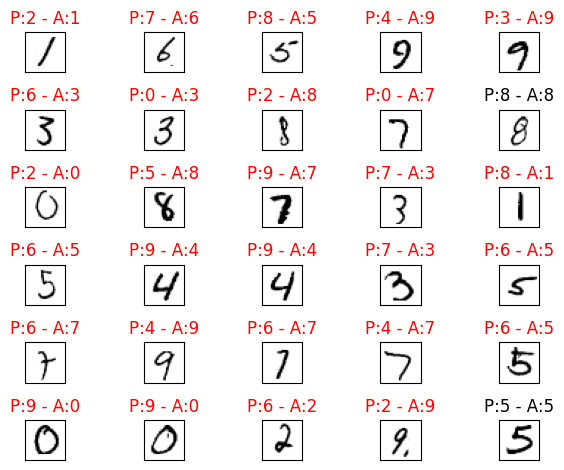

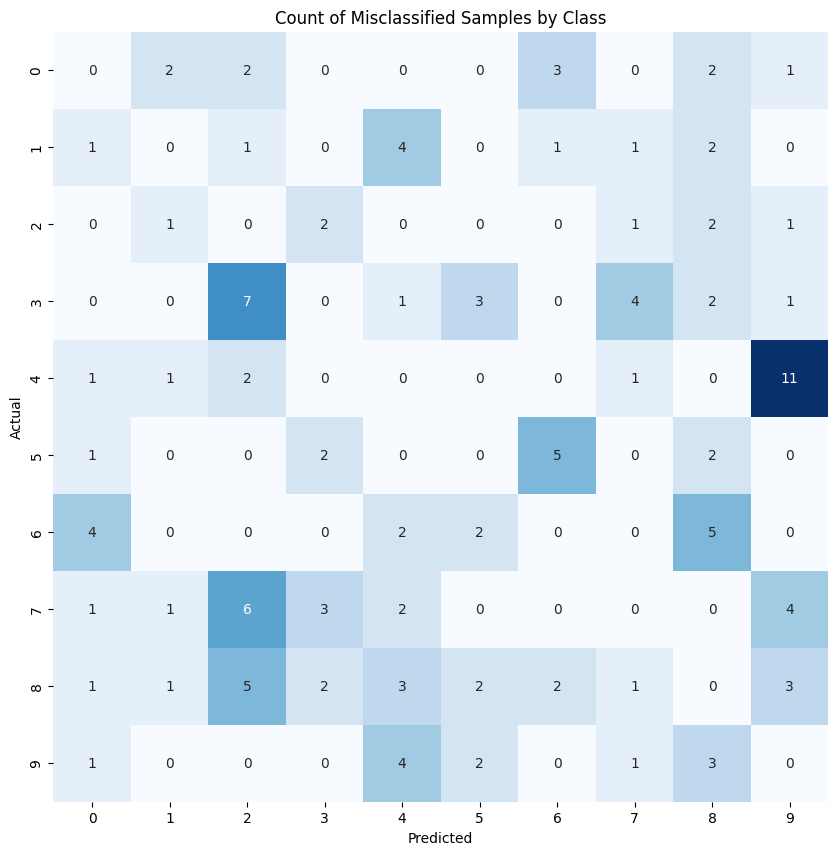

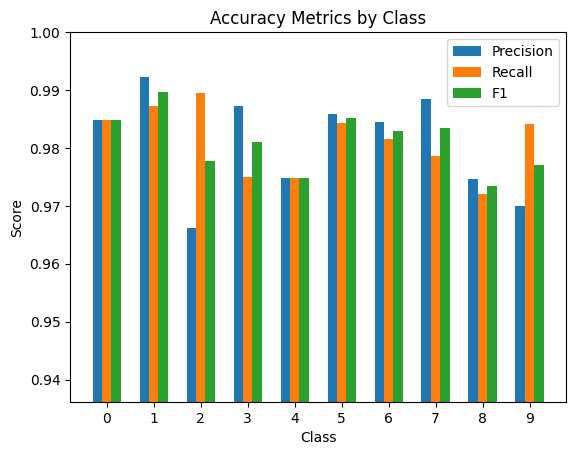

In [6]:
config = {
    'project': 'pytorch-demo',
    'tags': ['pytorch', 'demo'],
    'notes': 'First run with a simple CNN',
    'epochs': 20,
    'classes': 10,
    'kernels': [16, 32],
    'batch_size': 64,
    'optimizer': 'Adam',
    # 'learning_rates': 0.005,
    'learning_rates': [0.005, 0.001, 0.0005],
    'dataset': 'MNIST',
    'architecture': 'CNN',
}
# Build, train and analyze the model with the pipeline
model = model_pipeline(config)